#  Прогнозирование заказов такси

Сервис по заказу такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Необходимо построить модель для предсказания.

Значение метрики ***RMSE*** на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Работа будет выполняться согласно следующему ***плану***:

1. Загрузка и изучение данных;
2. Предобработка данных;
3. Анализ данных;
4. Подбор и генерация оптимального набора признаков;
5. Подбор, оценка кросс-валидацией и выбор наилучшей модели;
6. Тестирование выбранной модели.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Изучение данных

#  Прогнозирование заказов такси

Импортируем необходимые для работы библиотеки:

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

Загрузим исходные данные:

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

Выведем на экран первые и последние строки таблицы и общую информацию о данных:

In [4]:
display(data)
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


В датасете всего 26 496 строк. Пропуски данных отсутствуют. Периодичность записи данных в датасет - 10 минут.

Проверим датасет на наличие грубых дубликатов:

In [5]:
data.duplicated().sum()

0

Грубые дубликаты не обнаружены.

Выведем описательную статистику исходных данных и изучим диапазон данных:

In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


###### Вывод

Всего в таблице 2 столбца со следующими типами данных: ***object***, ***int64***.

Каждый объект в наборе данных — это информация о количестве заказов такси в аэропортах за 10 минут. Известно:

 - ***datetime*** — дата и время;
 - ***num_orders*** - количество заказов.

Тип данных столбца ***datetime*** - ***object***. Для возможности обработки временного ряда необходимо изменить тип данных столбца на ***datetime64*** и установить индекс таблицы равным столбцу ***datetime***.

## Предобработка данных

Изменим тип данных столбца ***datetime*** на ***datetime64***:

In [7]:
data['datetime'] = pd.to_datetime(data['datetime'])

Проверим результат:

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Тип данных успешно изменен.

Установим индекс таблицы равным столбцу ***datetime***:

In [9]:
data = data.set_index('datetime')

Проверим результат:

In [10]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Индекс установлен.

Проверим, в хронологическом ли порядке расположены даты и время:

In [11]:
print(data.index.is_monotonic)

True


Даты и время расположены в хронологическом порядке - нет необходимости сортировки индекса.

Так как по условию задачи необходимо будет спрогнозировать количество заказов такси на следующий час, выполним ресемплирование данных по одному часу:

In [12]:
data = data.resample('1H').sum()

Проверим результат ресемплирования:

In [13]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Данные ресемплированы.

###### Вывод

Тип данных столбца ***datetime*** был изменен с ***object*** на ***datetime64***.

***datetime*** установлен в качестве индекса и ресемплирован по одному часу.

## Анализ данных

Напишем функцию для анализа временного ряда:

In [14]:
def time_series_analysis(data, start, end, interval, plot_type, title):
    resampled = data[start:end].resample(interval).sum()
    decomposed = seasonal_decompose(resampled)
    plt.figure(figsize=(10,6))
    if plot_type == 'trend':
        decomposed.trend.plot(ax=plt.gca())
    elif plot_type == 'seasonal':
        decomposed.seasonal.plot(ax=plt.gca())
    plt.title(title)
    plt.show()

Рассмотрим тренд количества вызовов такси за весь имеющийся период:

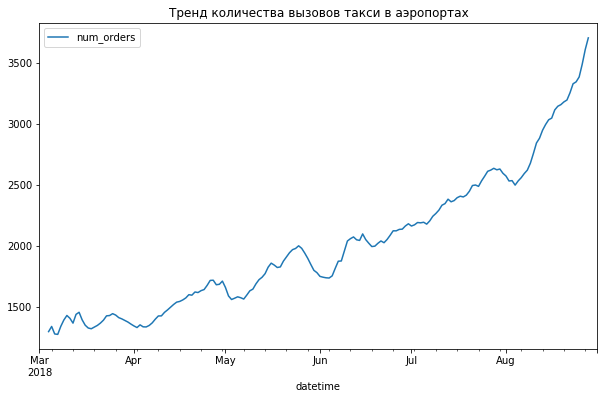

In [15]:
time_series_analysis(data,'2018-03','2018-08','1D','trend','Тренд количества вызовов такси в аэропортах')

Тренд растет от с начала марта по конец августа.

Рассмотрим дневную сезонность вызовов такси:

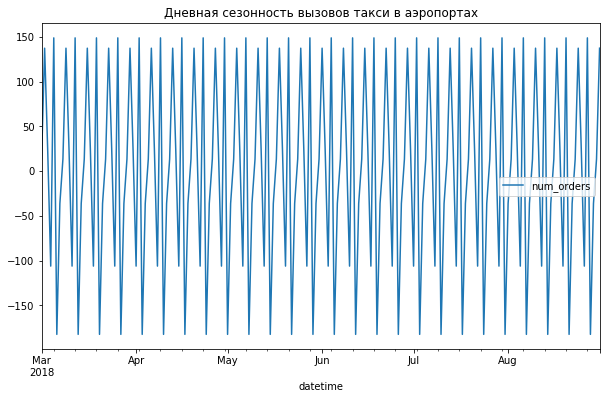

In [16]:
time_series_analysis(data,'2018-03','2018-08','1D','seasonal','Дневная сезонность вызовов такси в аэропортах')

Цикличность вызовов такси стационарна. Рассмотрим подробнее середину периода - май и июнь месяцы:

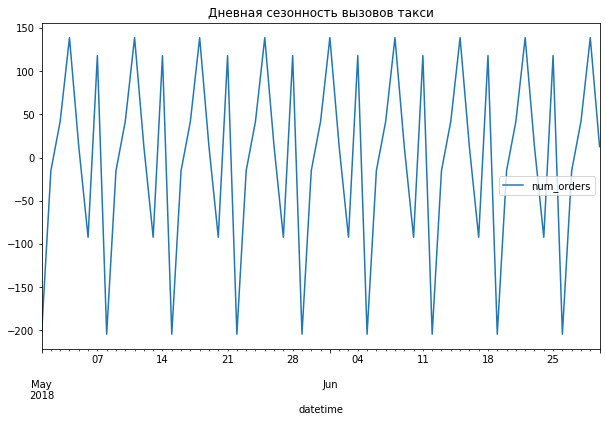

In [17]:
time_series_analysis(data,'2018-05','2018-06','1D','seasonal','Дневная сезонность вызовов такси')

Максимальные количества вызовов в мае месяце приходятся на: 4, 11, 18, 25 числа. Каждому из этих чисел соответствует день недели - ***пятница***, как и 1, 8, 15, 22 и 29 июня.

Минимальные количества вызовов в мае месяце приходятся на: 8, 15, 22, 29 числа. Каждому из этих чисел соответствует день недели - ***вторник***, как и 5, 12, 19 и 26 июня.

Рассмотрим часовую сезонность вызовов такси в аэропортах:

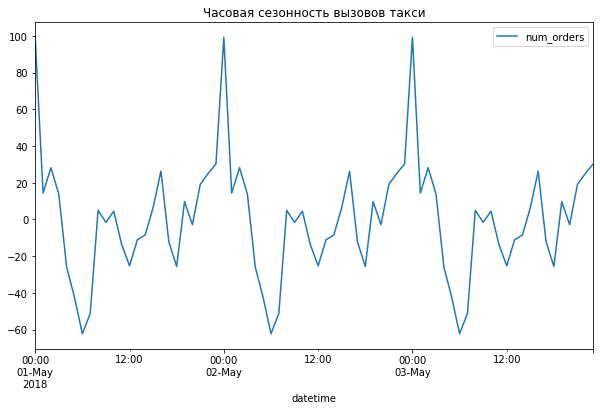

In [18]:
time_series_analysis(data,'2018-05-01','2018-05-03','1H','seasonal','Часовая сезонность вызовов такси')

Максимальное количество вызовов ежедневно приходится на: 0:00 часов.

Минимальное количество вызовов ежедневно приходится на: 6:00 часов.

###### Вывод

***Тренд*** количества вызываемых в аэропортах такси - ***возрастающий*** с начала марта до конца августа месяца. Количество вызовов достигает своего ***пика в конце августа***, что может быть связано с подходящим к концу сезону отпусков - люди возвращаются домой.

Небольшие просадки в количестве вызовов такси во время роста тренда могут быть связаны со специфическими событиями, например, праздничными днями или плохой погодой.

***Самыми загруженными*** днями недели для такси в аэропортах являются:

1. Пятница;
2. Понедельник;

***Наименее загруженными*** днями недели для такси в аэропортах являются:

1. Вторник;
2. Воскресенье.

По всей видимости, люди предпочитают избегать прилетать в точки назначения в выходные дни, и проводить их в спокойствии. Непопулярность вторника для перелетов может быть связана с тем, он считается самым продуктивным днем недели - слишком много дел, летать некогда.

***Наиболее загруженным*** временем для такси в аэропортах является ***0:00*** часов.

***Наименее загруженным*** временем для такси в аэропортах является: ***6:00*** часов.

## Подготовка признаков

В данных тренды и сезонность привязаны к конкретным датам. Для того, чтобы модели ML могли их распознать, необходимо добавить следующие признаки:

 - Месяцы;
 - Числа;
 - Дни недели;
 - Часы.

Также необходимо добавить столбцы с отстающими значениями ряда, которые подскажут, будет ли функция x(t) расти или уменьшаться.

Добавление в признаки скользящего среднего поможет задать общий тренд временного ряда.


Напишем функцию для создания признаков временного ряда:

In [19]:
def make_features(data, max_lag, rolling_mean_size):

#     data['month'] = data.index.month
#     data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

В цикле подберем такие ***max_lag*** и ***rolling_mean_size***, с помощью которых будут сгенерированы признаки, позволяющие модели линейной регрессии достичь минимальной метрики ***RMSE***. Метрика будет рассчитываться с помощью кросс-валидации с применением ***TimeSeriesSplit***.

In [20]:
max_lag = [6,12,18,24,30,36,42,48]
rolling_mean_size = [2,4,6,8,10,12,14,16,18,20,24]

exp_data = data

best_score = -48
best_lag = 0
best_size = 0

pd.options.mode.chained_assignment = None

for lag in max_lag:
    
    for size in rolling_mean_size:
        
        make_features(exp_data, lag, size)
        
        exp_data = exp_data.dropna()
        
        features = exp_data.drop('num_orders', axis = 1)
        target = exp_data['num_orders']

        features_train, features_test, target_train, target_test = train_test_split(
            features,
            target,
            shuffle=False,
            test_size=0.1
        )
        
        model = LinearRegression()
        score = cross_val_score(
            model,
            features_train,
            target_train,
            scoring = 'neg_root_mean_squared_error',
            cv = TimeSeriesSplit()
        ).mean()
        
        if score > best_score:
            best_score = score
            best_lag = lag
            best_size = size
        
result = pd.DataFrame({'best_lag':[best_lag], 'best_rolling_mean_size':[best_size], 'best_rmse_score':[best_score]})
display(result)


,best_lag,best_rolling_mean_size,best_rmse_score
0,24,2,-27.911374


Наилучший результат ***RMSE*** получен при обучении линейной регрессии на признаках, сформированных при ***max_lag = 24*** и ***rolling_mean_size = 2***.

С учетом полученных параметров сгенерируем признаки временного ряда для обучения и тестирования других моделей:

In [20]:
make_features(data, 24, 2)

In [21]:
data = data.dropna()

In [22]:
display(data.head())

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,85.5
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,74.0
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,105.0
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,97.5
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,69.5


Признаки успешно сгенерированы.

Разделим данные на выборки:

In [23]:
features = data.drop('num_orders', axis = 1)
target = data['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1
)

Проверим разделение:

In [24]:
print('Размер обучающей таблицы признаков:',features_train.shape)
print('Размер обучающей таблицы с целевым признаком:',target_train.shape)
print('Размер тестовой таблицы признаков:',features_test.shape)
print('Размер тестовой таблицы с целевым признаком:',target_test.shape)

Размер обучающей таблицы признаков: (3952, 27)
Размер обучающей таблицы с целевым признаком: (3952,)
Размер тестовой таблицы признаков: (440, 27)
Размер тестовой таблицы с целевым признаком: (440,)


Размеры выборок соответствуют заданным параметрам.

###### Вывод

На данном этапе с помощью подбора максимального отставания ряда ( ***max_lag*** ) и окна скользящего среднего ( ***rolling_mean_size*** ) были сгенерированы оптимальные признаки временного ряда.

Результат подбора признаков оценивался в цикле с помощью обучения модели ***Линейная регрессия***. Наилучший результат, оцениваемый с помощью кросс-валидации, ***RMSE = 27,91***, получен при ***max_lag = 24*** и ***rolling_mean_size = 2***.

## Обучение

Помимо уже примененной ***Линейной регресии*** рассмотрим другие модели, подбирая гиперпараметры для получения минимального значения метрики ***RMSE*** с помощью ***GridSearchCV***.

Напишем функцию для подбора наилучших параметров модели:

In [25]:
def get_best_params(model,parameters):
    grid = GridSearchCV(
    model,
    parameters,
    cv = TimeSeriesSplit(n_splits = 8),
    scoring = 'neg_root_mean_squared_error'
    )
    
    grid.fit(features_train,target_train)
    
    greed_result = pd.DataFrame(
        grid.cv_results_).sort_values(
        by = 'rank_test_score').reset_index(
        drop = True)
    
    display(greed_result[greed_result['rank_test_score']==1])

Рассмотрим модель ***Дерево решений***:

In [30]:
decision_tree = DecisionTreeRegressor()

In [31]:
get_best_params(
    decision_tree,
    {
        'max_depth':range(1,21,1),
        'random_state':[12345]
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016045,0.006331,0.002138,0.00025,5,12345,"{'max_depth': 5, 'random_state': 12345}",-26.575238,-29.159383,-31.442811,-28.368143,-37.6622,-30.641555,3.842698,1


Наилучшее значение метрики, ***RMSE = 30.60***, получено при максимальной глубине дерева = ***5***.

Рассмотрим модель ***Случайный лес***:

In [32]:
random_forest = RandomForestRegressor()

In [36]:
get_best_params(
    random_forest,
    {
        'max_depth':[11],
        'n_estimators': range(81,102,1),       
        'random_state':[12345]
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.649898,0.784904,0.013755,0.000489,11,89,12345,"{'max_depth': 11, 'n_estimators': 89, 'random_...",-22.039495,-22.020685,-23.697659,-25.15499,-33.190067,-25.220579,4.151986,1


Наилучшее значение метрики, ***RMSE = 25.22***, получено при максимальной глубине дерева = ***11*** и количестве деревьев = ***89***.

Рассмотрим модель ***CatBoostRegressor***:

In [37]:
cbr = cb.CatBoostRegressor()

In [39]:
get_best_params(
    cbr,
    {'silent':[True],
     'iterations':range(1,1001,100),
     'learning_rate':[0.1]           
    }
)    

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_iterations,param_learning_rate,param_silent,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,17.519664,4.106217,0.005247,0.001945,1000,0.1,True,"{'iterations': 1000, 'learning_rate': 0.1, 'si...",-21.030117,-21.740165,-22.321635,-24.029248,-31.310323,-24.086298,3.745622,1


Наилучшее значение метрики, ***RMSE = 24.09*** получено при следующих гиперпараметрах:
 - ***iterations*** = ***1000***;
 - ***learning_rate*** = ***0.1***.

###### Вывод

Наилучший результат на кросс-валидации, ***RMSE = 24.09***, продемонстрировала модель ***CatBoostRegressor***.

Далее протестируем данную модель.

## Тестирование

Определим время обучения модели:

In [27]:
%%time

cbr = cb.CatBoostRegressor(
    silent = True,
    iterations = 1000,
    learning_rate = 0.1,
)

cbr.fit(features_train, target_train)

CPU times: user 21.9 s, sys: 3.44 s, total: 25.3 s
Wall time: 26.6 s


Время обучения ***CatBoost Regressor*** = 25.3 секунд.

Рассчитаем время предсказания моделью целевого признака:

In [28]:
%%time
cbr_predictions = cbr.predict(features_test)

CPU times: user 827 µs, sys: 8.05 ms, total: 8.88 ms
Wall time: 3.47 ms


Время предсказания ***CatBoost Regressor*** = 8.88 милисекунд.

Рассчитаем ***RMSE*** модели на тестовой выборке:

In [29]:
rmse_сbr = mean_squared_error(target_test, cbr_predictions)**0.5
print('RMSE модели на тестовой выборке: ', rmse_сbr.round(0))

RMSE модели на тестовой выборке:  40.0


In [30]:
compare_data = pd.DataFrame(target_test).join(pd.DataFrame(cbr_predictions, index = target_test.index))
compare_data.columns = ['true','predictions']
# compare_data = compare_data.sort_values(by='predictions')
compare_data

,true,predictions
datetime,,
2018-08-13 16:00:00,144,157.312715
2018-08-13 17:00:00,152,153.408185
2018-08-13 18:00:00,104,127.247830
2018-08-13 19:00:00,91,110.234264
2018-08-13 20:00:00,82,101.398040
...,...,...
2018-08-31 19:00:00,136,142.832352
2018-08-31 20:00:00,154,176.915443
2018-08-31 21:00:00,159,188.718047


Построим диаграмму сравнения значения предсказаний и целевого признака:

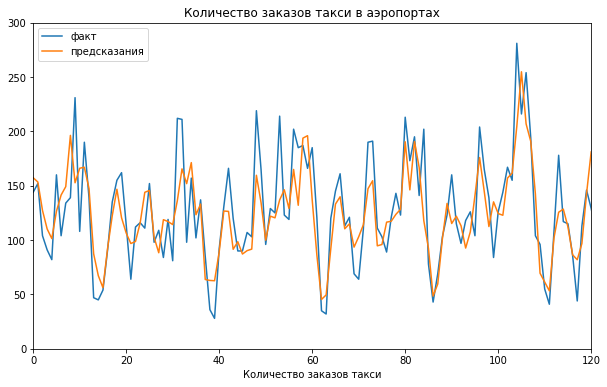

In [45]:
x = range(len(compare_data['true']))
plt.figure(figsize=(10,6))
plt.plot(x,compare_data['true'], label="факт")
plt.plot(x,compare_data['predictions'], label="предсказания")
plt.title("Количество заказов такси в аэропортах")
plt.legend()
plt.xlim(0,120)
plt.ylim(0,300)
plt.xlabel('Час')
plt.xlabel('Количество заказов такси')

plt.show()

Из построенной диаграммы сравнения видно, что примененная модель неплохо предсказывает тренд и сезонность вызовов такси, но предсказанные значения недостаточно точно попадают в точки минимумов и максимумов, что объясняет значение ***RMSE*** модели = ***40***.

## Общий вывод

В ходе данного проекта исторические данные о заказах такси в аэропортах были изучены, предобработаны и проанализированы с точки зрения направления тренда и сезонности.

Было выяснено, что количество вызываемых такси ***увеличивалось*** в период ***с начала марта по конец августа 2018***. Так период сбора данных небольшой - однозначно понять, с чем связан рост тренда - нельзя. Возможно, планомерно увеличивался таксопарк, а, возможно, люди больше летают в теплое время года - в августе традиционный сезон отпусков.

***Самым загруженным днем*** для сервиса такси определена ***пятница***, а ***самым спокойным - вторник***.

***Самым загруженным временем суток*** для сервиса такси является ***0:00***, а ***самым спокойным - 06:00***.

Более подробно с результатами анализа можно ознакомиться в выводе этапа 3.

С помощью подбора максимального отставания ряда ( ***max_lag*** ) и окна скользящего среднего ( ***rolling_mean_size*** ) были сгенерированы наиболее оптимальные признаки временного ряда, в дальнейшем использованные для обучения и исследования моделей машинного обучения с целью получения минимального значения ***RMSE***.

В работе были применены следующие алгоритмы машинного обучения:

 - ***Линейная регрессия***;
 - ***Дерево решений***;
 - ***Случайный лес***;
 - ***CatBoost Regressor***.
 
Наилучшей моделью по результатам кросс-валидации оказалась модель ***CatBoost Regressor*** (***RMSE = 24.09***). Данная модель была протестирована на время обучения, время предсказания целевого признака и качество на тестовой выборке. 
В итоге получено:

  - ***Время обучения*** модели: ***25.3*** секунд;
  - ***Время предсказания*** целевого признака: ***8.88*** милисекунд;
  - ***RMSE*** на тестовой выборке: **40**.
 
Полученное значение метрики не превышает 48, что в полной мере удовлетворяет условию поставленной задачи.